[UMAP](https://umap-learn.readthedocs.io/en/latest/) is a powerful dimensionality reduction tool which NVIDIA recently ported to GPUs with a python interface.  In this notebook we will demostrate basic usage, plotting, and timing comparisons between the CUDA (GPU) version of UMAP and the original CPU version of UMAP 

In [ ]:
!pip install seaborn
!pip install matplotlib

In [2]:
import os
import pandas as pd
import numpy as np

# CPU UMAP
import umap

# libraries for scoring/clustering
from sklearn.manifold.t_sne import trustworthiness

# GPU UMAP
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

In [3]:
# hide warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

We are going to work with the [fashion mnist](https://github.com/zalandoresearch/fashion-mnist) data set.  This is a dataset consisting of 70,000 28x28 grayscale images of clothing.

In [5]:
if not os.path.exists('data/fashion'):
    print("error, data is missing!")

In [6]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [7]:
train, train_labels = load_mnist('data/fashion', kind='train')
test, test_labels = load_mnist('data/fashion', kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

There are 60000 training images and 10000 test images

In [6]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

In [7]:
!nvidia-smi

Fri Apr 12 19:03:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:15:00.0 Off |                  Off |
| 31%   44C    P2    35W / 250W |  13922MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro GV100        Off  | 00000000:2D:00.0  On |                  Off |
| 37%   51C    P2    39W / 250W |   5352MiB / 32470MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
        

In [8]:
train[0].shape

(784,)

As mentioned previously, each row in the train matrix is an image

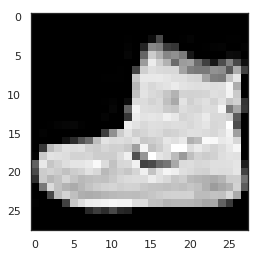

In [9]:
# display a Nike? sneaker
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

There is cost with moving data between host memory and device memory (GPU memory) and we will include that core when comparing speeds

In [10]:
%%time
record_data = (('fea%d'%i, data[:,i]) for i in range(data.shape[1]))
gdf = cudf.DataFrame(record_data)

CPU times: user 4.77 s, sys: 1.1 s, total: 5.87 s
Wall time: 5.87 s


In [11]:
%%timeit
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)

19.6 s ± 60.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`gdf` is a GPU backed dataframe -- all the data is stored in the device memory of the GPU.  With the data converted, we can apply the `cumlUMAP` the same inputs as we do for the standard UMAP.  Additionally, it should be noted that within cuml, [FAISS] https://github.com/facebookresearch/faiss) is used for extremely fast kNN and it's limited to single precision.  `cumlUMAP` will automatically downcast to `float32` when needed.

OK, now let's plot the output of the embeddings so that we can see the seperation of the neighborhoods.  Let's start by creating the classes.

In [13]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

In [14]:
#Needs to be redone because of timeit loses our variables sometimes
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)

/conda/envs/rapids/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Just as the original author of UMAP, Leland McInnes, states in the [UMAP docs](https://umap-learn.readthedocs.io/en/latest/supervised.html), we can plot the results and show the separation between the various classes defined above.

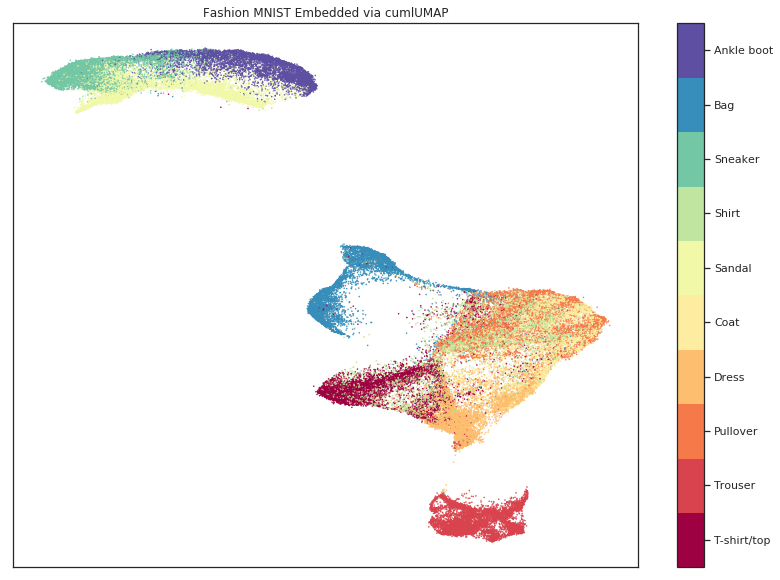

In [15]:
g_embedding_numpy = g_embedding.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via cumlUMAP');

Additionally, we can also quanititaviely compare the perfomance of `cumlUMAP` (GPU UMAP) to the reference/original implementation (CPU UMAP) using the [trustworthiness score](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/t_sne.py#L395).  From the docstring:

> Trustworthiness expresses to what extent the local structure is retained.  The trustworthiness is within [0, 1].


Like `t-SNE`, UMAP tries to capture both global and local structure and thus, we can apply the `trustworthiness` of the `g_embedding` data against the original input.  With a higher score we are demonstrating that the algorithm does a better and better job of local structure retention.  As [Corey Nolet](https://github.com/cjnolet) notes:
> Algorithms like UMAP aim to preserve local neighborhood structure and so measuring this property (trustworthiness) measures the algorithm's performance.

Scoring ~97% shows the GPU implementation is comparable to the original CPU implementation and the training time was ~9.5X faster